In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

In [3]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [4]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '61-efficientnetb0'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'
SUBMISSION_TTA_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta.csv'
SUBMISSION_TTA_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_last.csv'
SUBMISSION_TTA_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_blend.csv'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [5]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [ ]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers
# import tensorflow_addons as tfa

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [8]:
#@title
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 128,
  "EPOCHS": 12,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 25,
  "BASE_MODEL": 'EfficientNetB0',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB0',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'BATCH_SIZE': 128,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 12,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 25,
 'WIDTH': 256}

# Load data

In [9]:
#@title
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-65548a4c87d02212371fce6e9bd762100c34bf9b9ebbd04b0dd4b65b'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [10]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .6:
        if p_spatial2 >= .9:
            image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'], 180.)
        elif p_spatial2 >= .8:
            image['input_image'] = transform_zoom(image['input_image'], config['HEIGHT'], 8., 8.)
        elif p_spatial2 >= .7:
            image['input_image'] = transform_shift(image['input_image'], config['HEIGHT'], 8., 8.)
        else:
            image['input_image'] = transform_shear(image['input_image'], config['HEIGHT'], 2.)
        
    if p_crop >= .6: # crops
        if p_crop >= .8:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.8)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    if p_pixel >= .6: # Pixel-level transforms
        if p_pixel >= .9:
            image['input_image'] = tf.image.random_hue(image['input_image'], 0.01)
        elif p_pixel >= .8:
            image['input_image'] = tf.image.random_saturation(image['input_image'], 0.7, 1.3)
        elif p_pixel >= .7:
            image['input_image'] = tf.image.random_contrast(image['input_image'], 0.8, 1.2)
        else:
            image['input_image'] = tf.image.random_brightness(image['input_image'], 0.1)

    return image, label

## Auxiliary functions

In [11]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.normal([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.normal([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shift(image, height, h_shift, w_shift):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly shifted
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_shift = h_shift * tf.random.normal([1],dtype='float32') 
    width_shift = w_shift * tf.random.normal([1],dtype='float32') 
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shift_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_zoom(image, height, h_zoom, w_zoom):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly zoomed
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_zoom = 1.0 + tf.random.normal([1],dtype='float32')/h_zoom
    width_zoom = 1.0 + tf.random.normal([1],dtype='float32')/w_zoom
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(zoom_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

## Learning rate scheduler

Learning rate schedule: 5e-06 to 0.0003 to 7.86e-05


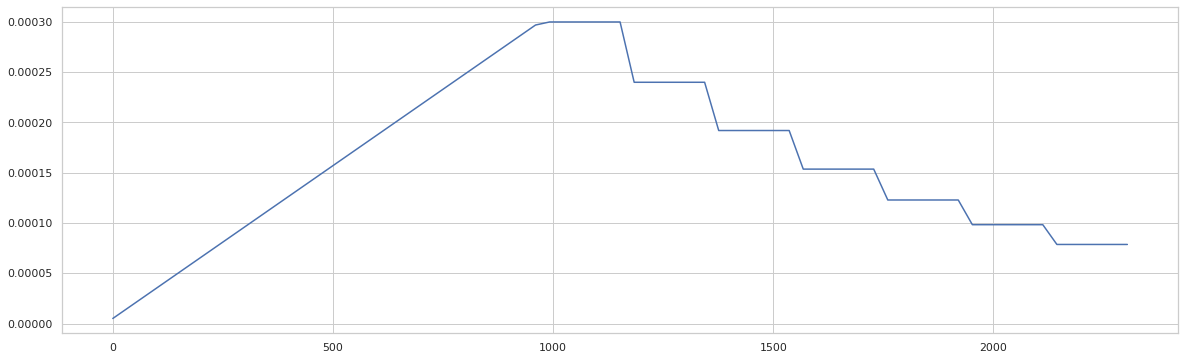

In [12]:
#@title
lr_min = 1e-6
lr_start = 5e-6
lr_max = config['LEARNING_RATE']
steps_per_epoch = 24844 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
hold_max_steps = 0
step_decay = .8
step_size = steps_per_epoch * 1

rng = [i for i in range(0, total_steps, 32)]
y = [step_schedule_with_warmup(tf.cast(x, tf.float32), step_size=step_size, 
                               warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                               lr_start=lr_start, lr_max=lr_max, step_decay=step_decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [13]:
#@title
# Initial bias
pos = len(k_fold[k_fold['target'] == 1])
neg = len(k_fold[k_fold['target'] == 0])
initial_bias = np.log([pos/neg])
print('Bias')
print(pos)
print(neg)
print(initial_bias)

# class weights
total = len(k_fold)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Class weight')
print(class_weight)

Bias
584
32542
[-4.02038586]
Class weight
{0: 0.5089730194825148, 1: 28.36130136986301}


In [14]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB0(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output', 
                     bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [15]:
# Evaluation
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)
# Test
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta_last = np.zeros((NUM_TEST_IMAGES, 1))

test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
test_image_data = test_dataset.map(lambda data, image_name: data)
test_tta_image_data = test_dataset_tta.map(lambda data, image_name: data)


history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_auc', mode='max', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_auc', mode='max', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: step_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                   step_size=step_size, warmup_steps=warmup_steps, 
                                                   hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                   lr_max=lr_max, step_decay=step_decay)
        
            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.2), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch ,
                            callbacks=[checkpoint, es],
                            class_weight=class_weight, 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print('Last model evaluation...')
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print('Last model inference...')
        test_preds_last += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (last) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta_last += model.predict(test_tta_image_data)

        ##### Best model #####
        print('Best model evaluation...')
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print('Best model inference...')
        test_preds += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (best) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta += model.predict(test_tta_image_data)


# normalize preds
test_preds /= config['N_USED_FOLDS']
test_preds_tta /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= config['N_USED_FOLDS']
test_preds_tta_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_tta = dict(zip(image_names_test, test_preds_tta.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))
name_preds_tta_last = dict(zip(image_names_test, test_preds_tta_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_tta'] = test.apply(lambda x: name_preds_tta[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)
test['target_tta_last'] = test.apply(lambda x: name_preds_tta_last[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.73.203.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.203.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


16703488/16696600 [==============================] - 0s 0us/step
Epoch 1/12
194/194 - 38s - auc: 0.6469 - loss: 1.5900 - val_auc: 0.7370 - val_loss: 0.4686
Epoch 2/12
194/194 - 25s - auc: 0.8419 - loss: 0.6102 - val_auc: 0.8505 - val_loss: 0.4626
Epoch 3/12
194/194 - 25s - auc: 0.8677 - loss: 0.5540 - val_auc: 0.8722 - val_loss: 0.4505
Epoch 4/12
194/194 - 24s - auc: 0.8807 - loss: 0.5383 - val_auc: 0.8695 - val_loss: 0.5293
Epoch 5/12
194/194 - 24s - auc: 0.8818 - loss: 0.5396 - val_auc: 0.8705 - val_loss: 0.5620
Epoch 6/12
194/194 - 24s - auc: 0.8882 - loss: 0.5376 - val_auc: 0.8678 - val_loss: 0.5389
Epoch 7/12
194/194 - 26s - auc: 0.9139 - loss: 0.5115 - val_auc: 0.8777 - val_loss: 0.6932
Epoch 8/12
194/194 - 26s - auc: 0.9284 - loss: 0.4850 - val_auc: 0.8865 - val_loss: 0.4325
Epoch 9/12
194/194 - 26s - auc: 0.9372 - loss: 0.4864 - val_auc: 0.8912 - val_loss: 0.4950
Epoch 10/12
194/194 - 26s - auc: 0.9475 - loss: 0.4639 - val_auc: 0.8977 - val_loss: 0.4889
Epoch 11/12
194/194 - 24

INFO:tensorflow:Initializing the TPU system: grpc://10.73.203.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.203.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
210/210 - 40s - auc: 0.6361 - loss: 1.5178 - val_auc: 0.7696 - val_loss: 0.4693
Epoch 2/12
210/210 - 27s - auc: 0.8422 - loss: 0.5887 - val_auc: 0.8637 - val_loss: 0.4629
Epoch 3/12
210/210 - 27s - auc: 0.8686 - loss: 0.5492 - val_auc: 0.8687 - val_loss: 0.5589
Epoch 4/12
210/210 - 27s - auc: 0.8741 - loss: 0.5456 - val_auc: 0.8760 - val_loss: 0.5713
Epoch 5/12
210/210 - 25s - auc: 0.8840 - loss: 0.5416 - val_auc: 0.8578 - val_loss: 0.5591
Epoch 6/12
210/210 - 27s - auc: 0.9006 - loss: 0.5180 - val_auc: 0.8830 - val_loss: 0.4979
Epoch 7/12
210/210 - 27s - auc: 0.9210 - loss: 0.4998 - val_auc: 0.8956 - val_loss: 0.5234
Epoch 8/12
210/210 - 27s - auc: 0.9324 - loss: 0.4834 - val_auc: 0.8981 - val_loss: 0.4500
Epoch 9/12
210/210 - 27s - auc: 0.9445 - loss: 0.4706 - val_auc: 0.9010 - val_loss: 0.4985
Epoch 10/12
210/210 - 25s - auc: 0.9499 - loss: 0.4611 - val_auc: 0.8971 - val_loss: 0.5148
Epoch 11/12
210/210 - 25s - auc: 0.9621 - loss: 0.4440 - val_auc: 0.9007 - val_loss: 0.43

INFO:tensorflow:Initializing the TPU system: grpc://10.73.203.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.203.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
210/210 - 40s - auc: 0.6325 - loss: 1.4396 - val_auc: 0.7781 - val_loss: 0.4601
Epoch 2/12
210/210 - 27s - auc: 0.8335 - loss: 0.6007 - val_auc: 0.8636 - val_loss: 0.4834
Epoch 3/12
210/210 - 27s - auc: 0.8627 - loss: 0.5543 - val_auc: 0.8756 - val_loss: 0.4719
Epoch 4/12
210/210 - 26s - auc: 0.8763 - loss: 0.5409 - val_auc: 0.8718 - val_loss: 0.4964
Epoch 5/12
210/210 - 27s - auc: 0.8816 - loss: 0.5399 - val_auc: 0.8842 - val_loss: 0.5161
Epoch 6/12
210/210 - 26s - auc: 0.8970 - loss: 0.5202 - val_auc: 0.8800 - val_loss: 0.4914
Epoch 7/12
210/210 - 25s - auc: 0.9141 - loss: 0.5016 - val_auc: 0.8837 - val_loss: 0.4747
Epoch 8/12
210/210 - 27s - auc: 0.9243 - loss: 0.4931 - val_auc: 0.8846 - val_loss: 0.4898
Epoch 9/12
210/210 - 27s - auc: 0.9410 - loss: 0.4760 - val_auc: 0.8921 - val_loss: 0.4812
Epoch 10/12
210/210 - 27s - auc: 0.9504 - loss: 0.4622 - val_auc: 0.8987 - val_loss: 0.4603
Epoch 11/12
210/210 - 25s - auc: 0.9548 - loss: 0.4518 - val_auc: 0.8961 - val_loss: 0.44

INFO:tensorflow:Initializing the TPU system: grpc://10.73.203.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.203.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
210/210 - 38s - auc: 0.6271 - loss: 1.5090 - val_auc: 0.7555 - val_loss: 0.4450
Epoch 2/12
210/210 - 27s - auc: 0.8416 - loss: 0.5857 - val_auc: 0.8677 - val_loss: 0.4341
Epoch 3/12
210/210 - 27s - auc: 0.8639 - loss: 0.5526 - val_auc: 0.8692 - val_loss: 0.5101
Epoch 4/12
210/210 - 27s - auc: 0.8743 - loss: 0.5447 - val_auc: 0.8817 - val_loss: 0.4512
Epoch 5/12
210/210 - 27s - auc: 0.8852 - loss: 0.5319 - val_auc: 0.8857 - val_loss: 0.5137
Epoch 6/12
210/210 - 25s - auc: 0.8984 - loss: 0.5227 - val_auc: 0.8845 - val_loss: 0.4560
Epoch 7/12
210/210 - 27s - auc: 0.9205 - loss: 0.4962 - val_auc: 0.8994 - val_loss: 0.5773
Epoch 8/12
210/210 - 27s - auc: 0.9314 - loss: 0.4882 - val_auc: 0.9060 - val_loss: 0.4555
Epoch 9/12
210/210 - 27s - auc: 0.9432 - loss: 0.4718 - val_auc: 0.9090 - val_loss: 0.4730
Epoch 10/12
210/210 - 25s - auc: 0.9544 - loss: 0.4529 - val_auc: 0.8906 - val_loss: 0.4081
Epoch 11/12
210/210 - 25s - auc: 0.9604 - loss: 0.4496 - val_auc: 0.9000 - val_loss: 0.44

INFO:tensorflow:Initializing the TPU system: grpc://10.73.203.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.203.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
210/210 - 40s - auc: 0.6627 - loss: 1.4326 - val_auc: 0.8282 - val_loss: 0.4585
Epoch 2/12
210/210 - 27s - auc: 0.8364 - loss: 0.6084 - val_auc: 0.8728 - val_loss: 0.4382
Epoch 3/12
210/210 - 27s - auc: 0.8584 - loss: 0.5622 - val_auc: 0.8849 - val_loss: 0.4786
Epoch 4/12
210/210 - 25s - auc: 0.8758 - loss: 0.5466 - val_auc: 0.8833 - val_loss: 0.5587
Epoch 5/12
210/210 - 27s - auc: 0.8868 - loss: 0.5387 - val_auc: 0.8863 - val_loss: 0.4725
Epoch 6/12
210/210 - 28s - auc: 0.8938 - loss: 0.5290 - val_auc: 0.8977 - val_loss: 0.4707
Epoch 7/12
210/210 - 27s - auc: 0.9202 - loss: 0.5000 - val_auc: 0.9086 - val_loss: 0.4693
Epoch 8/12
210/210 - 27s - auc: 0.9308 - loss: 0.4889 - val_auc: 0.9126 - val_loss: 0.5020
Epoch 9/12
210/210 - 25s - auc: 0.9414 - loss: 0.4735 - val_auc: 0.9048 - val_loss: 0.4311
Epoch 10/12
210/210 - 25s - auc: 0.9453 - loss: 0.4744 - val_auc: 0.9058 - val_loss: 0.4484
Epoch 11/12
210/210 - 25s - auc: 0.9539 - loss: 0.4579 - val_auc: 0.9000 - val_loss: 0.43

## Model loss graph

Fold: 1


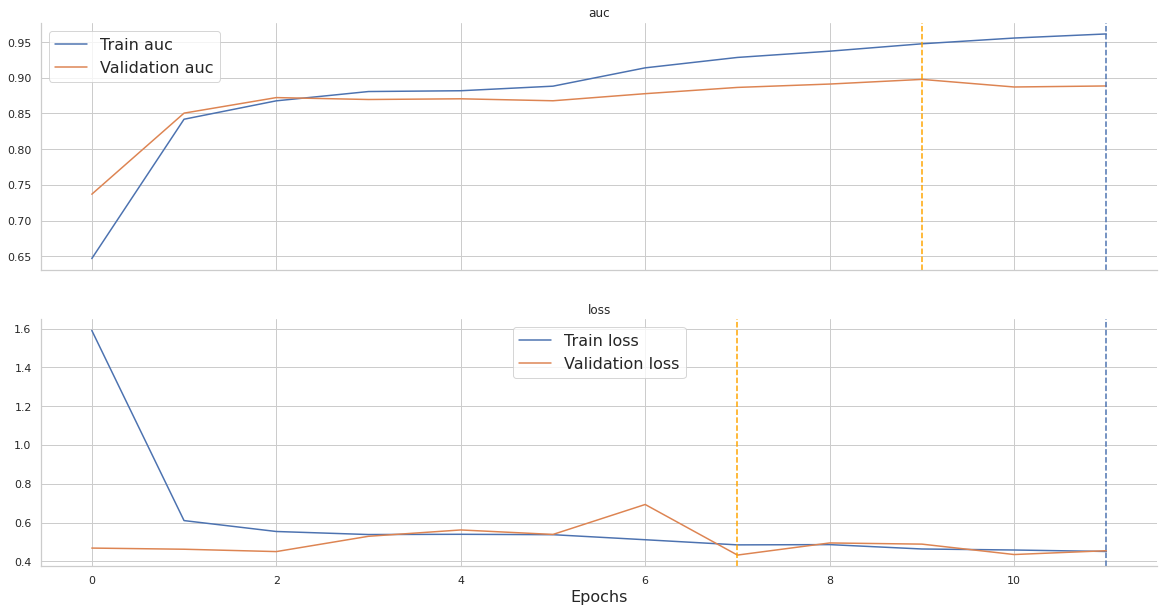

Fold: 2


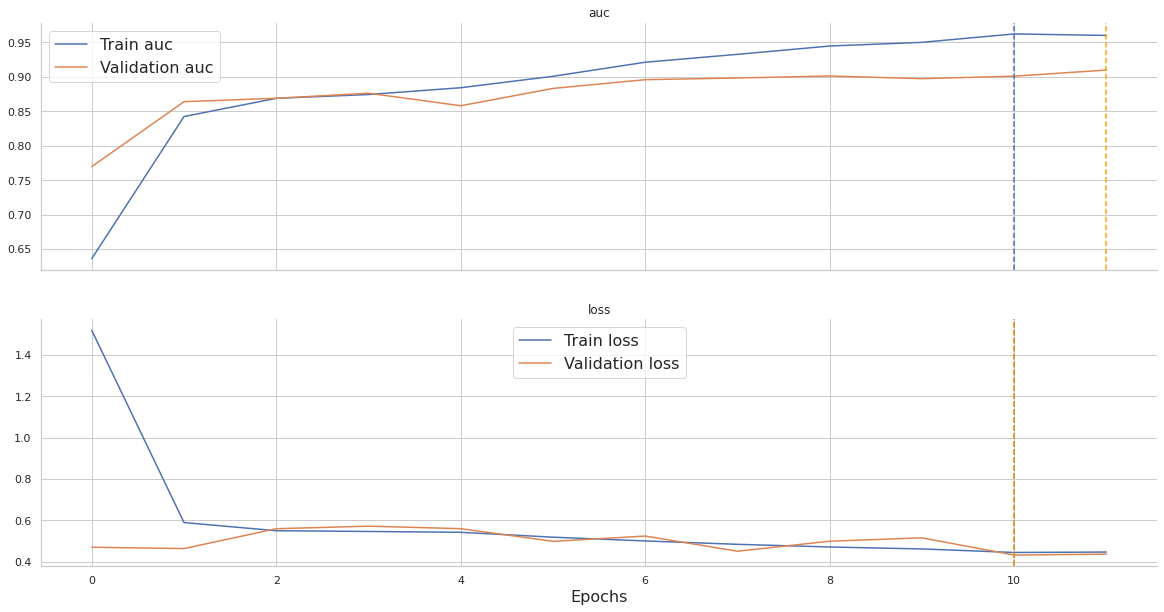

Fold: 3


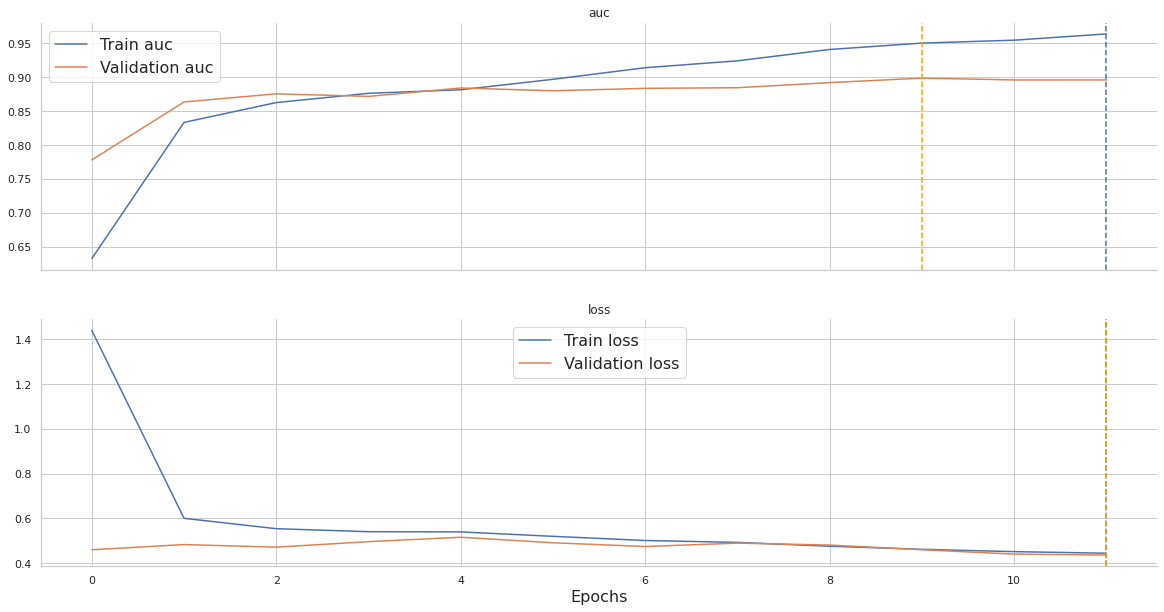

Fold: 4


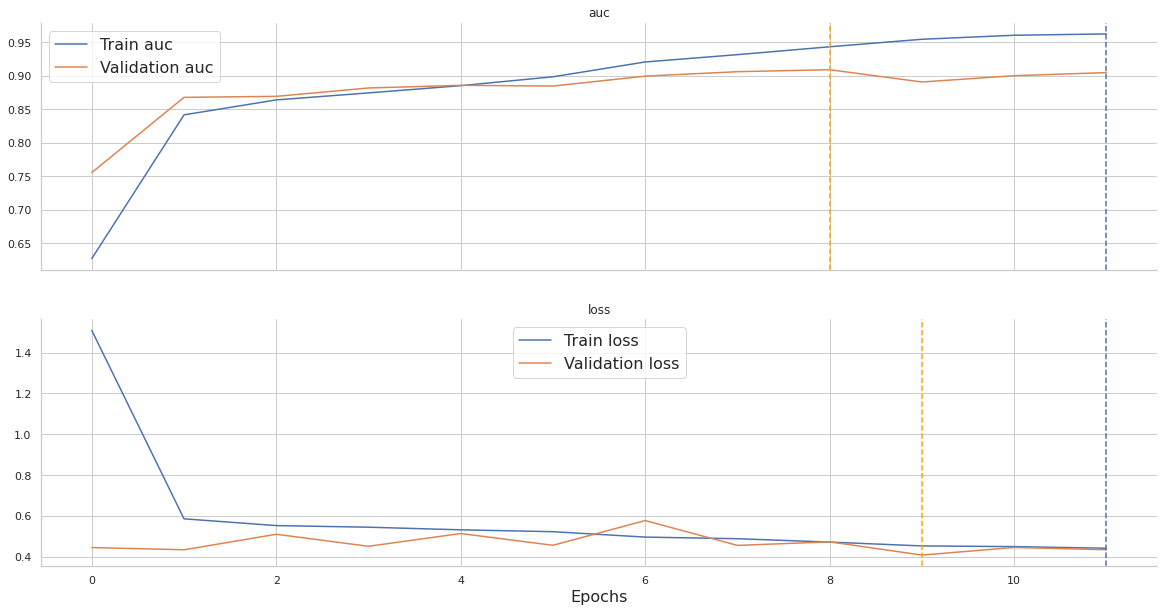

Fold: 5


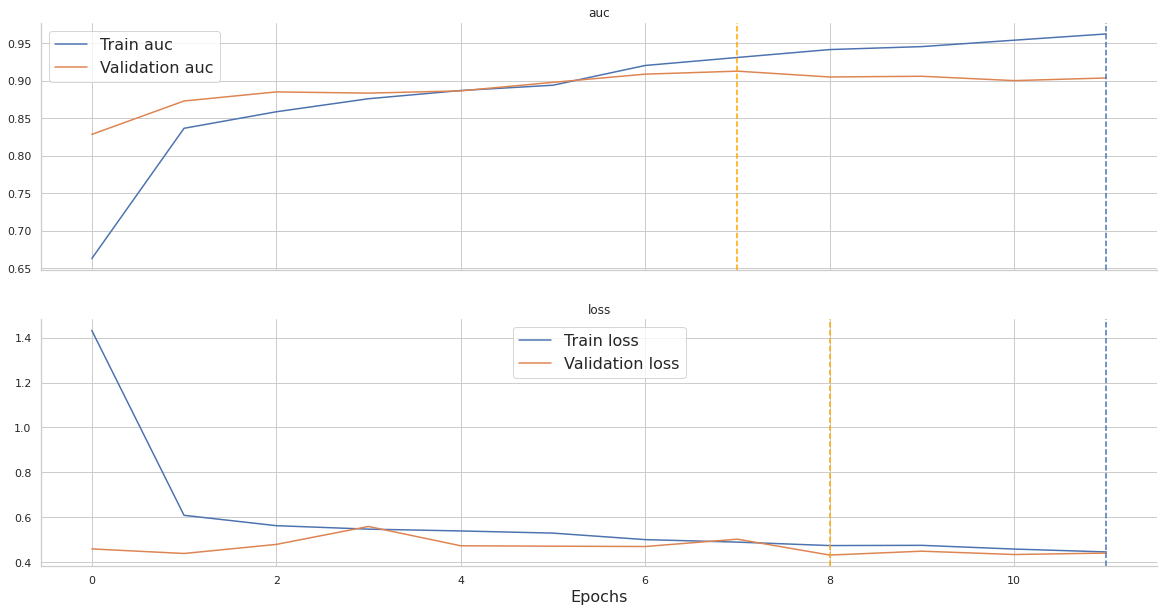

In [16]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

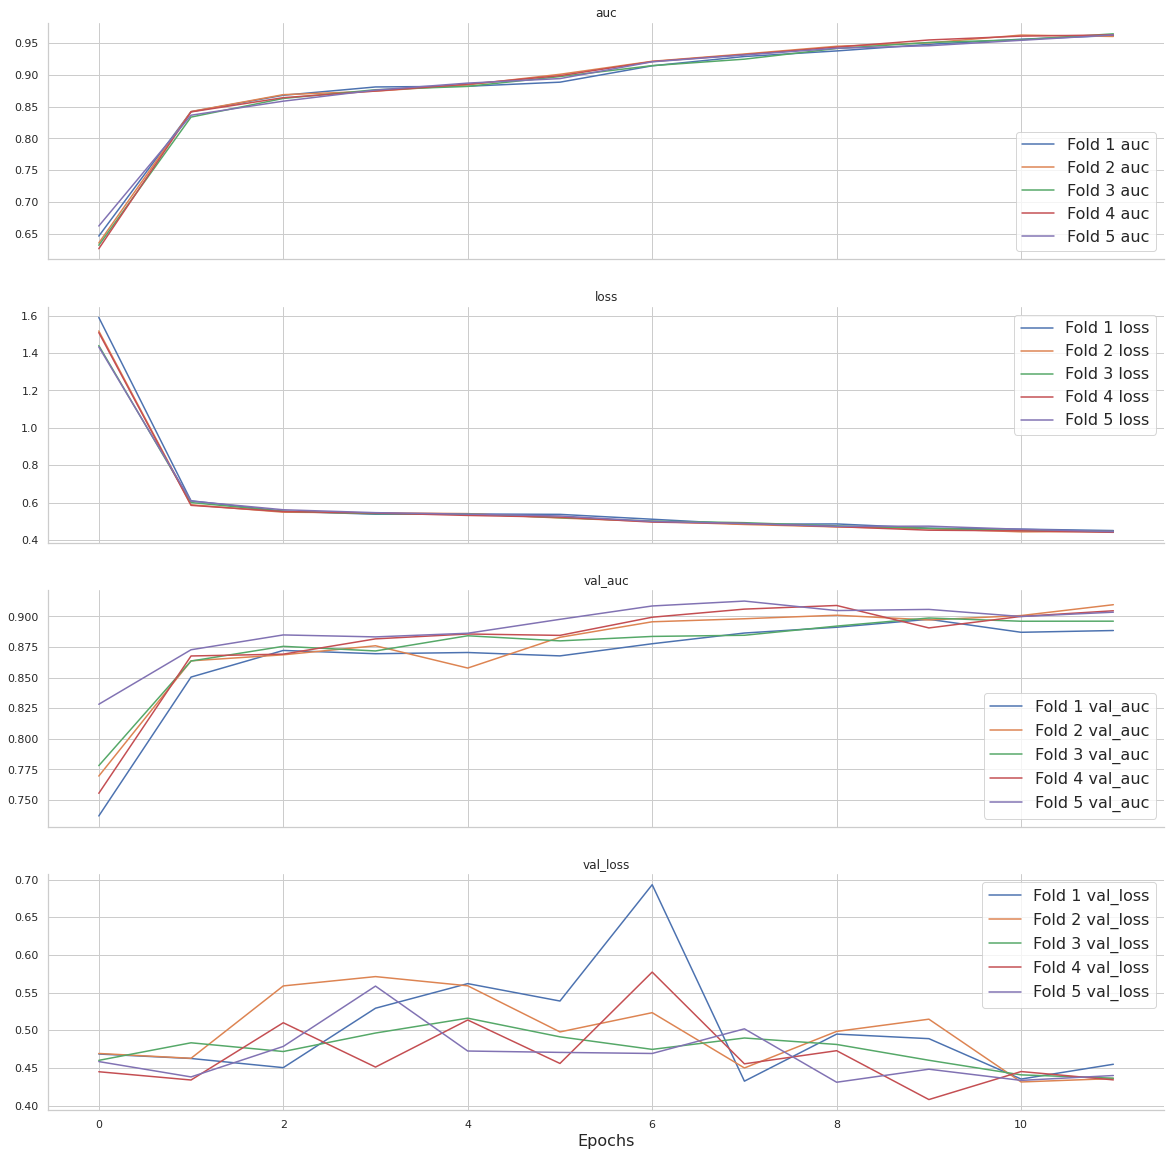

In [17]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation (best)

In [18]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.981862,0.905961,0.075901,0.984447,0.898266,0.990418,0.910440,0.984088,0.898893,0.978192,0.909086,0.972165,0.913119
Accuracy,0.877390,0.870693,0.006696,0.871830,0.861178,0.919221,0.900209,0.890462,0.886528,0.862608,0.858778,0.842827,0.846773
Precision,0.129364,0.098121,0.031243,0.121931,0.088835,0.178760,0.115964,0.135199,0.108466,0.111486,0.091880,0.099445,0.085462
Recall,0.986016,0.754425,0.231591,0.997743,0.773050,0.997890,0.700000,0.974522,0.725664,0.980932,0.767857,0.978992,0.805556
F1-score,0.227746,0.173139,0.054607,0.217306,0.159357,0.303205,0.198966,0.237455,0.188723,0.200216,0.164122,0.180550,0.154529
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.981862,0.905961,0.075901,0.984447,0.898266,0.990418,0.910440,0.984088,0.898893,0.978192,0.909086,0.972165,0.913119
male,0.980278,0.910859,0.069419,0.982925,0.916721,0.989213,0.898432,0.981036,0.923392,0.977629,0.904824,0.970586,0.910925
female,0.983224,0.894351,0.088874,0.985686,0.870664,0.991669,0.928842,0.987459,0.843625,0.978076,0.913680,0.973233,0.914943
head/neck,0.970498,0.887245,0.083253,0.969871,0.893837,0.983721,0.871578,0.962138,0.875232,0.976611,0.905841,0.960149,0.889736
upper extremity,0.982683,0.891139,0.091544,0.984368,0.870611,0.988803,0.912168,0.986131,0.900412,0.979664,0.897975,0.974448,0.874527
lower extremity,0.985182,0.876606,0.108577,0.988743,0.859263,0.991867,0.881567,0.986989,0.873563,0.981430,0.891321,0.976882,0.877315
torso,0.981161,0.925942,0.055219,0.984078,0.931439,0.991011,0.937051,0.985011,0.908534,0.974893,0.915153,0.970814,0.937533
0 <= age < 26,0.974246,0.847920,0.126327,0.980346,0.867483,0.985858,0.768561,0.977108,0.934053,0.971317,0.793013,0.956603,0.876488
26 <= age < 40,0.985545,0.910346,0.075198,0.988920,0.955030,0.995114,0.841549,0.989689,0.907125,0.981955,0.912130,0.972046,0.935897


# Model evaluation (last)

In [19]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.988819,0.900957,0.087863,0.989029,0.889703,0.990500,0.911592,0.987075,0.895567,0.988681,0.904061,0.988812,0.903861
Accuracy,0.912655,0.901997,0.010659,0.909025,0.894013,0.919333,0.900048,0.914502,0.907130,0.915425,0.902144,0.904990,0.906647
Precision,0.167040,0.116934,0.050106,0.162644,0.105038,0.178963,0.116942,0.167756,0.127010,0.170259,0.113885,0.155578,0.121795
Recall,0.988436,0.691746,0.296690,0.988713,0.695035,0.997890,0.709091,0.980892,0.699115,0.987288,0.651786,0.987395,0.703704
F1-score,0.285716,0.199955,0.085761,0.279337,0.182495,0.303497,0.200772,0.286512,0.214966,0.290433,0.193891,0.268802,0.207650
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.988819,0.900957,0.087863,0.989029,0.889703,0.990500,0.911592,0.987075,0.895567,0.988681,0.904061,0.988812,0.903861
male,0.987745,0.907144,0.080601,0.988546,0.906189,0.989344,0.899688,0.984617,0.916833,0.987517,0.905387,0.988699,0.907621
female,0.989736,0.887885,0.101851,0.989071,0.863847,0.991695,0.929923,0.989887,0.846186,0.989652,0.901707,0.988375,0.897763
head/neck,0.982071,0.885326,0.096745,0.984113,0.920930,0.983607,0.873968,0.971451,0.878019,0.985771,0.854579,0.985414,0.899136
upper extremity,0.989696,0.891002,0.098695,0.989178,0.872638,0.988604,0.914248,0.989012,0.904304,0.989173,0.897578,0.992515,0.866240
lower extremity,0.990750,0.861558,0.129192,0.990617,0.826338,0.992009,0.882566,0.988155,0.863415,0.991350,0.904342,0.991617,0.831127
torso,0.988142,0.920680,0.067463,0.988860,0.918691,0.991191,0.938293,0.987981,0.906205,0.986928,0.907917,0.985751,0.932293
0 <= age < 26,0.985966,0.826401,0.159565,0.989438,0.887413,0.986253,0.767401,0.981587,0.928657,0.983292,0.742358,0.989262,0.806176
26 <= age < 40,0.992238,0.900578,0.091660,0.990675,0.923442,0.995146,0.842639,0.993201,0.872109,0.988497,0.933668,0.993672,0.931030


# Confusion matrix

Fold: 1


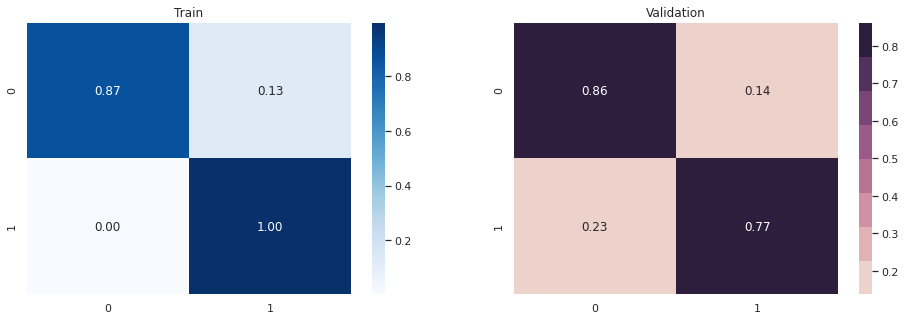

Fold: 2


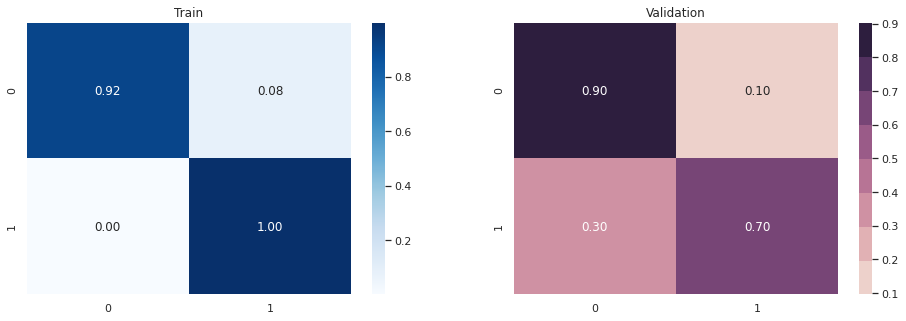

Fold: 3


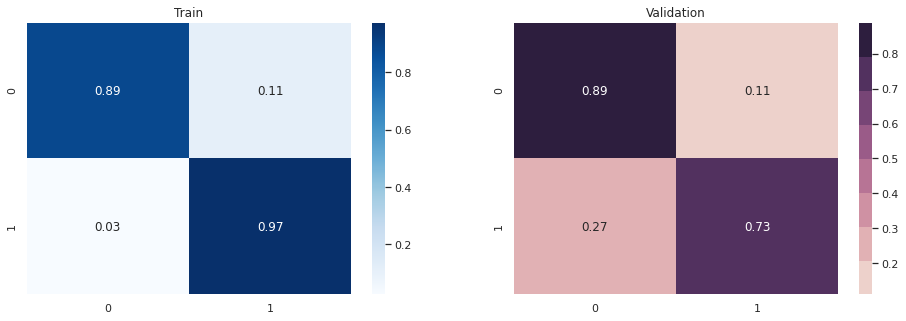

Fold: 4


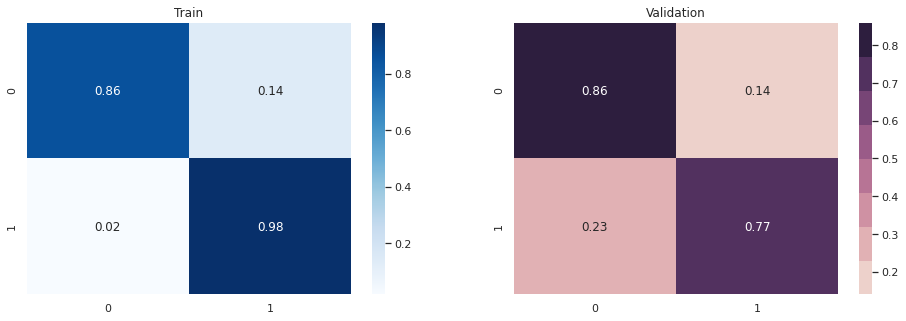

Fold: 5


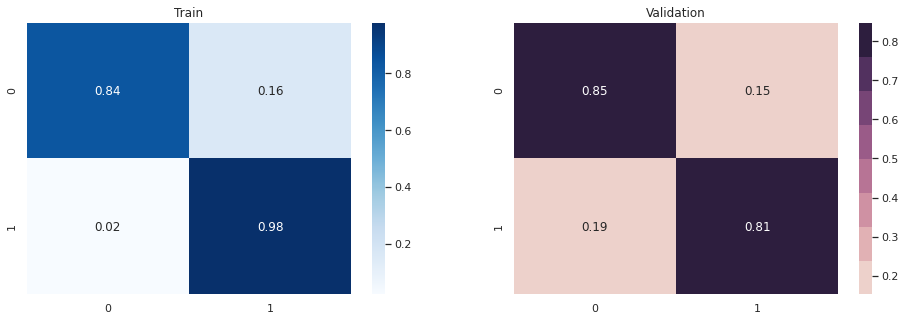

In [20]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [21]:
#@title
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 3143
Train positive correct predictions: 581
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.197631,0.086105,0.167451,0.364207,0.166863,0.203527
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.045135,0.053061,0.045104,0.042040,0.040301,0.045168
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.052006,0.062775,0.043087,0.044490,0.038996,0.070681
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.210470,0.298419,0.116082,0.270802,0.278042,0.089002
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.049483,0.043185,0.047010,0.054246,0.051596,0.051380
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.070756,0.065308,0.058755,0.052167,0.102742,0.074809
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.137170,0.144351,0.081022,0.082185,0.116560,0.261732
7,ISIC_0075663,female,35.0,torso,unknown,0,0.115351,0.143222,0.056778,0.166900,0.110755,0.099100
8,ISIC_0075914,male,30.0,torso,unknown,0,0.105761,0.072725,0.082683,0.114303,0.183200,0.075891
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.084685,0.099454,0.053524,0.075261,0.081287,0.113900


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.692638,0.044039,0.965901,0.609935,0.948827,0.894487
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.846618,0.622066,0.842637,0.901511,0.918471,0.948404
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.800737,0.938699,0.898597,0.313710,0.921470,0.931211
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.678943,0.679270,0.754116,0.270834,0.748846,0.941649
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.741222,0.190094,0.920249,0.836619,0.954130,0.805016
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.898246,0.912482,0.939396,0.906140,0.795595,0.937615
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.902606,0.976215,0.788500,0.862315,0.975423,0.910580
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.842120,0.735827,0.864035,0.791721,0.897744,0.921274
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.831853,0.770978,0.823481,0.850566,0.945985,0.768256
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.838830,0.946833,0.897629,0.637970,0.805991,0.905729


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
10,ISIC_0076545,male,55.0,upper extremity,unknown,0,0.676417,0.655918,0.338835,0.760736,0.882767,0.743829
20,ISIC_0080817,male,50.0,lower extremity,unknown,0,0.508635,0.343391,0.298432,0.646566,0.741485,0.513302
48,ISIC_0092870,male,55.0,torso,unknown,0,0.626107,0.224351,0.906899,0.772133,0.771092,0.456061
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.692638,0.044039,0.965901,0.609935,0.948827,0.894487
95,ISIC_0150975,female,50.0,lower extremity,unknown,0,0.578542,0.788716,0.525468,0.202196,0.713794,0.662536
111,ISIC_0155012,male,55.0,torso,nevus,0,0.624570,0.356661,0.741795,0.788409,0.521716,0.714272
117,ISIC_0156642,female,40.0,torso,nevus,0,0.520468,0.861705,0.326348,0.351289,0.618136,0.444859
123,ISIC_0159060,male,55.0,head/neck,unknown,0,0.659574,0.763219,0.588998,0.636054,0.637689,0.671908
128,ISIC_0159996,female,60.0,head/neck,unknown,0,0.759552,0.743518,0.830213,0.733117,0.620628,0.870282
151,ISIC_0165449,male,60.0,torso,unknown,0,0.541857,0.495307,0.519757,0.486956,0.520647,0.686615


# Visualize test predictions

In [22]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print(f"Test predictions (tta) {len(test[test['target_tta'] > .5])}|{len(test[test['target_tta'] <= .5])}")
print(f"Test predictions (last tta) {len(test[test['target_tta_last'] > .5])}|{len(test[test['target_tta_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 1631|9351
Test predictions (last) 1243|9739
Test predictions (tta) 1730|9252
Test predictions (last tta) 1247|9735
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
0,ISIC_0052060,male,70.0,NaN,0.071301,0.063116,0.087866,0.078132
1,ISIC_0052349,male,40.0,lower extremity,0.054889,0.058463,0.064197,0.057227
2,ISIC_0058510,female,55.0,torso,0.058388,0.065482,0.080228,0.086980
3,ISIC_0073313,female,50.0,torso,0.068154,0.083142,0.066353,0.082662
4,ISIC_0073502,female,45.0,lower extremity,0.284678,0.196317,0.277108,0.191566
5,ISIC_0074618,male,50.0,lower extremity,0.160331,0.106224,0.159582,0.134228
6,ISIC_0076801,male,45.0,upper extremity,0.156823,0.100869,0.248600,0.162712
7,ISIC_0077586,male,50.0,lower extremity,0.290485,0.249411,0.292030,0.245087
8,ISIC_0082004,female,45.0,torso,0.202137,0.151888,0.248818,0.161766
9,ISIC_0082785,male,65.0,lower extremity,0.127831,0.120292,0.162705,0.143998


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
18,ISIC_0097719,male,45.0,torso,0.676409,0.639118,0.593343,0.540698
19,ISIC_0099348,female,45.0,upper extremity,0.523117,0.534471,0.540901,0.541247
22,ISIC_0105104,male,40.0,torso,0.523785,0.508913,0.463930,0.406543
24,ISIC_0112420,female,65.0,torso,0.814951,0.786718,0.843995,0.797559
42,ISIC_0155983,male,70.0,torso,0.811320,0.791722,0.843489,0.825499
56,ISIC_0169906,male,85.0,torso,0.753206,0.743660,0.737652,0.731382
57,ISIC_0171865,male,65.0,palms/soles,0.687206,0.611350,0.712437,0.626019
61,ISIC_0175798,female,55.0,torso,0.682813,0.683108,0.718622,0.733527
64,ISIC_0178235,female,70.0,lower extremity,0.633165,0.642499,0.639319,0.607830
69,ISIC_0182213,female,80.0,head/neck,0.646195,0.651278,0.662365,0.645485


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
18,ISIC_0097719,male,45.0,torso,0.676409,0.639118,0.593343,0.540698
19,ISIC_0099348,female,45.0,upper extremity,0.523117,0.534471,0.540901,0.541247
22,ISIC_0105104,male,40.0,torso,0.523785,0.508913,0.463930,0.406543
24,ISIC_0112420,female,65.0,torso,0.814951,0.786718,0.843995,0.797559
42,ISIC_0155983,male,70.0,torso,0.811320,0.791722,0.843489,0.825499
56,ISIC_0169906,male,85.0,torso,0.753206,0.743660,0.737652,0.731382
57,ISIC_0171865,male,65.0,palms/soles,0.687206,0.611350,0.712437,0.626019
61,ISIC_0175798,female,55.0,torso,0.682813,0.683108,0.718622,0.733527
64,ISIC_0178235,female,70.0,lower extremity,0.633165,0.642499,0.639319,0.607830
69,ISIC_0182213,female,80.0,head/neck,0.646195,0.651278,0.662365,0.645485


# Test set predictions

In [23]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
submission['target_tta'] = test['target_tta']
submission['target_tta_last'] = test['target_tta_last']
submission['target_tta_blend'] = (test['target_tta'] * .5) +  (test['target_tta_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

### TTA ###
submission_tta = submission[['image_name', 'target_tta']]
submission_tta.columns = ['image_name', 'target']
submission_tta.to_csv(SUBMISSION_TTA_PATH, index=False)

### TTA LAST ###
submission_tta_last = submission[['image_name', 'target_tta_last']]
submission_tta_last.columns = ['image_name', 'target']
submission_tta_last.to_csv(SUBMISSION_TTA_LAST_PATH, index=False)

### TTA BLEND ###
submission_blend_tta = submission[['image_name', 'target_tta_blend']]
submission_blend_tta.columns = ['image_name', 'target']
submission_blend_tta.to_csv(SUBMISSION_TTA_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
0,ISIC_0052060,0.071301,0.063116,0.067208,0.087866,0.078132,0.082999
1,ISIC_0052349,0.054889,0.058463,0.056676,0.064197,0.057227,0.060712
2,ISIC_0058510,0.058388,0.065482,0.061935,0.080228,0.086980,0.083604
3,ISIC_0073313,0.068154,0.083142,0.075648,0.066353,0.082662,0.074507
4,ISIC_0073502,0.284678,0.196317,0.240498,0.277108,0.191566,0.234337
5,ISIC_0074618,0.160331,0.106224,0.133277,0.159582,0.134228,0.146905
6,ISIC_0076801,0.156823,0.100869,0.128846,0.248600,0.162712,0.205656
7,ISIC_0077586,0.290485,0.249411,0.269948,0.292030,0.245087,0.268558
8,ISIC_0082004,0.202137,0.151888,0.177012,0.248818,0.161766,0.205292
9,ISIC_0082785,0.127831,0.120292,0.124061,0.162705,0.143998,0.153351


,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000
mean,0.250092,0.217464,0.233778,0.260366,0.222058,0.241212
std,0.208391,0.194101,0.199911,0.208687,0.193462,0.199812
min,0.033867,0.033230,0.035368,0.037322,0.036485,0.036971
25%,0.087060,0.082137,0.084926,0.093052,0.083780,0.088842
50%,0.164426,0.130781,0.148123,0.177761,0.136291,0.157563
75%,0.354845,0.283160,0.320333,0.377091,0.296781,0.336246
max,0.945194,0.946457,0.945825,0.927776,0.946127,0.936779
